https://zhuanlan.zhihu.com/p/435945714

In [1]:
import torch
from torch import nn, Tensor, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch_geometric import datasets
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader, ClusterData, ClusterLoader
from torch_geometric import transforms as gtransforms
from torch_geometric.utils import to_networkx
import networkx as nx
from tqdm import tqdm
from plotly import express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device

'cuda:0'

In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# torch_geometric.data.Data

节点和节点之间的边构成了图。所以在 PyG 中，如果你要构建图，那么需要两个要素：节点和边。PyG 提供了torch_geometric.data.Data (下面简称Data) 用于构建图，包括 5 个属性，每一个属性都不是必须的，可以为空。

- x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`
- y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`
- edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
- pos: 存储节点的坐标，形状是 `[num_nodes, num_dimensions]`
- edge_attr: 存储边的特征。形状是 `[num_edges, num_edge_features]`

In [4]:
# x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`。
x = torch.tensor(
    [[2,  1],
     [5,  6],
     [3,  7],
     [12, 0]],
    dtype=torch.float
)
x

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [5]:
# y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`。
y = torch.tensor(
    [[0],
     [2],
     [3],
     [4]],
    dtype=torch.long
)
y

tensor([[0],
        [2],
        [3],
        [4]])

In [6]:
# edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
# 5条边: (0 -> 1), (0 -> 2), (1 -> 2), (1 -> 3), (2 -> 3)
edge_index = torch.tensor(
    [[0, 1, 0, 1, 1, 2, 3],
     [1, 0, 2, 2, 3, 3, 2]],
    dtype=torch.long
)
edge_index

tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]])

In [7]:
data = Data(x=x, y=y, edge_index=edge_index)
data

Data(x=[4, 2], edge_index=[2, 7], y=[4, 1])

In [8]:
for i in data:
    print(i)

('x', tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]]))
('edge_index', tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]]))
('y', tensor([[0],
        [2],
        [3],
        [4]]))


In [9]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

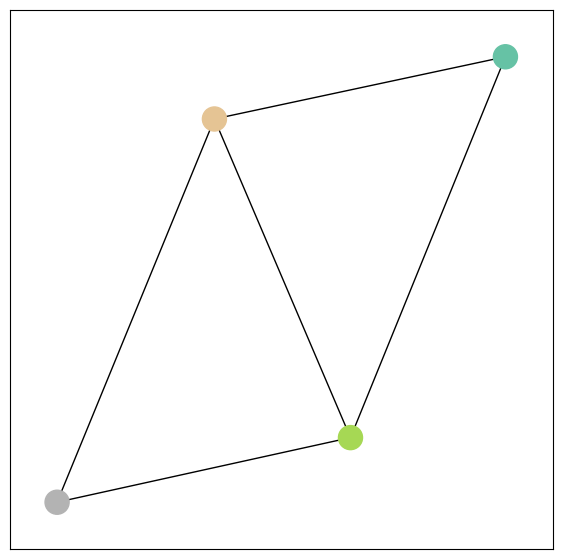

In [10]:
visualize_graph(to_networkx(data, to_undirected=True), color=data.y)

# from torch_geometric.datasets

In [11]:
transform = gtransforms.Compose([
    gtransforms.NormalizeFeatures(),
])
transform

Compose([
  NormalizeFeatures()
])

| Name          | #graphs | #nodes | #edges  | #features | #classes |
| ------------- | ------- | ------ | ------- | --------- | -------- |
| MUTAG         | 188     | ~17.9  | ~39.6   | 7         | 2        |
| ENZYMES       | 600     | ~32.6  | ~124.3  | 3         | 6        |
| PROTEINS      | 1,113   | ~39.1  | ~145.6  | 3         | 2        |
| COLLAB        | 5,000   | ~74.5  | ~4914.4 | 0         | 3        |
| IMDB-BINARY   | 1,000   | ~19.8  | ~193.1  | 0         | 2        |
| REDDIT-BINARY | 2,000   | ~429.6 | ~995.5  | 0         | 2        |

In [12]:
dataset = datasets.Planetoid(
    root="./datasets/Planetoid",
    name="Cora",                # [Cora, PubMed]
    transform=transform,
)
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
dataset = dataset.shuffle()
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [14]:
dataset.num_edge_features

0

In [15]:
dataset.num_node_features

1433

In [16]:
dataset.num_features, dataset.num_classes

(1433, 7)

In [17]:
type(dataset), type(dataset[0])

(torch_geometric.datasets.planetoid.Planetoid, torch_geometric.data.data.Data)

In [18]:
cluster_data = ClusterData(dataset[0], num_parts=128)  # 1. Create subgraphs.
train_dataloader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

Computing METIS partitioning...
Done!


In [19]:
for i, batch in enumerate(train_dataloader):
    print(batch)
    print("x: \t\t",        batch.x.shape)          # [batch_sum, num_features] 图的每一条数据的长度不一定相等,batch_sum代表这个batch中的全部节点数据
    print("edge_index: \t", batch.edge_index.shape) # 代表边的连接
    print("y: \t\t",        batch.y.shape)          # 类别
    print("y: \t\t",        y)
    if i >= 5:
        break

Data(x=[677, 1433], y=[677], train_mask=[677], val_mask=[677], test_mask=[677], edge_index=[2, 1632])
x: 		 torch.Size([677, 1433])
edge_index: 	 torch.Size([2, 1632])
y: 		 torch.Size([677])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
Data(x=[678, 1433], y=[678], train_mask=[678], val_mask=[678], test_mask=[678], edge_index=[2, 1568])
x: 		 torch.Size([678, 1433])
edge_index: 	 torch.Size([2, 1568])
y: 		 torch.Size([678])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
Data(x=[677, 1433], y=[677], train_mask=[677], val_mask=[677], test_mask=[677], edge_index=[2, 1646])
x: 		 torch.Size([677, 1433])
edge_index: 	 torch.Size([2, 1646])
y: 		 torch.Size([677])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
Data(x=[676, 1433], y=[676], train_mask=[676], val_mask=[676], test_mask=[676], edge_index=[2, 1660])
x: 		 torch.Size([676, 1433])
edge_index: 	 torch.Size([2, 1660])
y: 		 torch.Size([676])
y: 		 tensor([[0],
        [2],
        [3],
        [4

In [20]:
batch.x.shape

torch.Size([676, 1433])

# Model

In [21]:
class Net(nn.Module):
    def __init__(
        self,
        in_channels: int = dataset.num_features,
        out_channels: int = dataset.num_classes,
        hidden_channels: int = 256,
        depth: int = 3,
        pool_ratios: float = 0.5,
    ) -> None:
        super().__init__()
        self.gnn = gnn.GraphUNet(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            depth=depth,
            pool_ratios=pool_ratios,
            sum_res=True,
            act='relu',
        )

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor = None) -> Tensor:
        x = self.gnn(x, edge_index)
        return x

In [22]:
net = Net().to(device)
net

Net(
  (gnn): GraphUNet(1433, 256, 7, depth=3, pool_ratios=[0.5, 0.5, 0.5])
)

In [23]:
optimizer = optim.Adam(params=net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [24]:
epochs = 100

In [25]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=optimizer.state_dict()['param_groups'][0]['lr'] * 0.01)
lr_scheduler

In [26]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

# train

In [27]:
train_accuracies = []
train_lossess    = []
val_accuracies   = []
val_lossess      = []
for epoch in range(1, epochs + 1):
    net.train()
    train_y_trues = []
    train_y_preds = []
    train_losses  = []
    pbar = tqdm(total=len(train_dataloader), desc=f"train-epoch: {epoch}")
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
        y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_y_trues.append(y)
        train_y_preds.append(y_pred.argmax(dim=-1))
        train_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    lr_scheduler.step()

    # 准确率
    train_y_trues_ = torch.cat(train_y_trues)
    train_y_preds_ = torch.cat(train_y_preds)
    train_accuracy = (train_y_trues_ == train_y_preds_).float().sum().divide(len(train_y_trues_))
    train_accuracies.append(train_accuracy.item())
    train_lossess.append(torch.tensor(train_losses).mean().item())


    # net.eval()
    # val_y_trues = []
    # val_y_preds = []
    # val_losses  = []
    # pbar = tqdm(total=len(val_dataloader), desc=f"val-epoch: {epoch}")
    # for batch in val_dataloader:
    #     x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
    #     x, edge_index, batch, y = x.to(device), edge_index.to(device), batch.to(device), y.to(device)
    #     with torch.inference_mode():
    #         y_pred = net(x, edge_index, batch)
    #     loss: Tensor = loss_fn(y_pred, y)

    #     val_y_trues.append(y)
    #     val_y_preds.append(y_pred.argmax(dim=-1))
    #     val_losses.append(loss.item())
    #     pbar.update(1)
    #     pbar.set_postfix({"loss": loss.item()})
    # pbar.close()

    # # 准确率
    # val_y_trues_ = torch.cat(val_y_trues)
    # val_y_preds_ = torch.cat(val_y_preds)
    # val_accuracy = (val_y_trues_ == val_y_preds_).float().sum().divide(len(val_y_trues_))
    # val_accuracies.append(val_accuracy.item())
    # val_lossess.append(torch.tensor(val_losses).mean().item())

    print(f"\033[0;31;40mepoch: {epoch}\033[0m " +
        f"\033[0;32;40mtrain_accuracy = {train_accuracy.item()}\033[0m ")

train-epoch: 1:   0%|          | 0/4 [00:00<?, ?it/s]d:\miniconda3\envs\pytorch\Lib\site-packages\torch_geometric\utils\sparse.py:264: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(
train-epoch: 1: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s, loss=1.93]


epoch: 1 train_accuracy = 0.25886261463165283 


train-epoch: 2: 100%|██████████| 4/4 [00:00<00:00, 30.77it/s, loss=1.9] 


epoch: 2 train_accuracy = 0.30539143085479736 


train-epoch: 3: 100%|██████████| 4/4 [00:00<00:00, 30.30it/s, loss=1.87]


epoch: 3 train_accuracy = 0.3024372160434723 


train-epoch: 4: 100%|██████████| 4/4 [00:00<00:00, 31.36it/s, loss=1.82]


epoch: 4 train_accuracy = 0.3028064966201782 


train-epoch: 5: 100%|██████████| 4/4 [00:00<00:00, 28.86it/s, loss=1.69]


epoch: 5 train_accuracy = 0.3035450577735901 


train-epoch: 6: 100%|██████████| 4/4 [00:00<00:00, 29.85it/s, loss=1.6] 


epoch: 6 train_accuracy = 0.30391430854797363 


train-epoch: 7: 100%|██████████| 4/4 [00:00<00:00, 28.78it/s, loss=1.61]


epoch: 7 train_accuracy = 0.3249630630016327 


train-epoch: 8: 100%|██████████| 4/4 [00:00<00:00, 28.78it/s, loss=1.61]


epoch: 8 train_accuracy = 0.34379616379737854 


train-epoch: 9: 100%|██████████| 4/4 [00:00<00:00, 29.63it/s, loss=1.64]


epoch: 9 train_accuracy = 0.37407681345939636 


train-epoch: 10: 100%|██████████| 4/4 [00:00<00:00, 28.99it/s, loss=1.47]


epoch: 10 train_accuracy = 0.47045788168907166 


train-epoch: 11: 100%|██████████| 4/4 [00:00<00:00, 27.78it/s, loss=1.3] 


epoch: 11 train_accuracy = 0.5302806496620178 


train-epoch: 12: 100%|██████████| 4/4 [00:00<00:00, 27.86it/s, loss=1.39]


epoch: 12 train_accuracy = 0.5528064966201782 


train-epoch: 13: 100%|██████████| 4/4 [00:00<00:00, 29.41it/s, loss=1.29]


epoch: 13 train_accuracy = 0.5779172778129578 


train-epoch: 14: 100%|██████████| 4/4 [00:00<00:00, 30.08it/s, loss=1.17]


epoch: 14 train_accuracy = 0.597858190536499 


train-epoch: 15: 100%|██████████| 4/4 [00:00<00:00, 29.85it/s, loss=1.45]


epoch: 15 train_accuracy = 0.6805760860443115 


train-epoch: 16: 100%|██████████| 4/4 [00:00<00:00, 29.63it/s, loss=1.27]


epoch: 16 train_accuracy = 0.7082718014717102 


train-epoch: 17: 100%|██████████| 4/4 [00:00<00:00, 29.85it/s, loss=1.3] 


epoch: 17 train_accuracy = 0.6901772618293762 


train-epoch: 18: 100%|██████████| 4/4 [00:00<00:00, 29.41it/s, loss=1.05]


epoch: 18 train_accuracy = 0.6853766441345215 


train-epoch: 19: 100%|██████████| 4/4 [00:00<00:00, 28.87it/s, loss=1.14]


epoch: 19 train_accuracy = 0.7141801714897156 


train-epoch: 20: 100%|██████████| 4/4 [00:00<00:00, 30.07it/s, loss=1.09]


epoch: 20 train_accuracy = 0.7241506576538086 


train-epoch: 21: 100%|██████████| 4/4 [00:00<00:00, 30.53it/s, loss=1.04] 


epoch: 21 train_accuracy = 0.7315361499786377 


train-epoch: 22: 100%|██████████| 4/4 [00:00<00:00, 30.53it/s, loss=1.03] 


epoch: 22 train_accuracy = 0.7189807891845703 


train-epoch: 23: 100%|██████████| 4/4 [00:00<00:00, 29.63it/s, loss=0.895]


epoch: 23 train_accuracy = 0.7477843165397644 


train-epoch: 24: 100%|██████████| 4/4 [00:00<00:00, 27.03it/s, loss=0.812]


epoch: 24 train_accuracy = 0.7315361499786377 


train-epoch: 25: 100%|██████████| 4/4 [00:00<00:00, 30.77it/s, loss=0.797]


epoch: 25 train_accuracy = 0.7717872858047485 


train-epoch: 26: 100%|██████████| 4/4 [00:00<00:00, 30.77it/s, loss=0.769]


epoch: 26 train_accuracy = 0.7924667596817017 


train-epoch: 27: 100%|██████████| 4/4 [00:00<00:00, 31.10it/s, loss=0.768]


epoch: 27 train_accuracy = 0.7994830012321472 


train-epoch: 28: 100%|██████████| 4/4 [00:00<00:00, 29.85it/s, loss=0.739]


epoch: 28 train_accuracy = 0.7932053208351135 


train-epoch: 29: 100%|██████████| 4/4 [00:00<00:00, 29.85it/s, loss=0.808]


epoch: 29 train_accuracy = 0.8098227381706238 


train-epoch: 30: 100%|██████████| 4/4 [00:00<00:00, 29.85it/s, loss=0.716]


epoch: 30 train_accuracy = 0.8179467916488647 


train-epoch: 31: 100%|██████████| 4/4 [00:00<00:00, 27.59it/s, loss=0.884]


epoch: 31 train_accuracy = 0.8194239139556885 


train-epoch: 32: 100%|██████████| 4/4 [00:00<00:00, 30.08it/s, loss=0.723]


epoch: 32 train_accuracy = 0.826440155506134 


train-epoch: 33: 100%|██████████| 4/4 [00:00<00:00, 30.53it/s, loss=0.718]


epoch: 33 train_accuracy = 0.8223780989646912 


train-epoch: 34: 100%|██████████| 4/4 [00:00<00:00, 28.45it/s, loss=0.768]


epoch: 34 train_accuracy = 0.8268094658851624 


train-epoch: 35: 100%|██████████| 4/4 [00:00<00:00, 30.77it/s, loss=0.681]


epoch: 35 train_accuracy = 0.8279172778129578 


train-epoch: 36: 100%|██████████| 4/4 [00:00<00:00, 25.32it/s, loss=0.674]


epoch: 36 train_accuracy = 0.8334563970565796 


train-epoch: 37: 100%|██████████| 4/4 [00:00<00:00, 24.84it/s, loss=0.638]


epoch: 37 train_accuracy = 0.8327178359031677 


train-epoch: 38: 100%|██████████| 4/4 [00:00<00:00, 25.00it/s, loss=0.67] 


epoch: 38 train_accuracy = 0.8382570147514343 


train-epoch: 39: 100%|██████████| 4/4 [00:00<00:00, 25.64it/s, loss=0.62] 


epoch: 39 train_accuracy = 0.829763650894165 


train-epoch: 40: 100%|██████████| 4/4 [00:00<00:00, 19.56it/s, loss=0.607]


epoch: 40 train_accuracy = 0.8293943405151367 


train-epoch: 41: 100%|██████████| 4/4 [00:00<00:00, 25.64it/s, loss=0.645]


epoch: 41 train_accuracy = 0.841211199760437 


train-epoch: 42: 100%|██████████| 4/4 [00:00<00:00, 24.54it/s, loss=0.508]


epoch: 42 train_accuracy = 0.844534695148468 


train-epoch: 43: 100%|██████████| 4/4 [00:00<00:00, 21.74it/s, loss=0.653]


epoch: 43 train_accuracy = 0.8497045636177063 


train-epoch: 44: 100%|██████████| 4/4 [00:00<00:00, 26.45it/s, loss=0.537]


epoch: 44 train_accuracy = 0.8467503786087036 


train-epoch: 45: 100%|██████████| 4/4 [00:00<00:00, 26.35it/s, loss=0.506]


epoch: 45 train_accuracy = 0.8456425070762634 


train-epoch: 46: 100%|██████████| 4/4 [00:00<00:00, 28.64it/s, loss=0.459]


epoch: 46 train_accuracy = 0.836410641670227 


train-epoch: 47: 100%|██████████| 4/4 [00:00<00:00, 28.37it/s, loss=0.6]  


epoch: 47 train_accuracy = 0.8556129932403564 


train-epoch: 48: 100%|██████████| 4/4 [00:00<00:00, 28.02it/s, loss=0.634]


epoch: 48 train_accuracy = 0.8386262655258179 


train-epoch: 49: 100%|██████████| 4/4 [00:00<00:00, 28.83it/s, loss=0.494]


epoch: 49 train_accuracy = 0.8353027701377869 


train-epoch: 50: 100%|██████████| 4/4 [00:00<00:00, 29.62it/s, loss=0.491]


epoch: 50 train_accuracy = 0.8389955759048462 


train-epoch: 51: 100%|██████████| 4/4 [00:00<00:00, 29.83it/s, loss=0.586]


epoch: 51 train_accuracy = 0.8397340774536133 


train-epoch: 52: 100%|██████████| 4/4 [00:00<00:00, 30.53it/s, loss=0.558]


epoch: 52 train_accuracy = 0.8319792747497559 


train-epoch: 53: 100%|██████████| 4/4 [00:00<00:00, 30.21it/s, loss=0.539]


epoch: 53 train_accuracy = 0.841211199760437 


train-epoch: 54: 100%|██████████| 4/4 [00:00<00:00, 26.93it/s, loss=0.554]


epoch: 54 train_accuracy = 0.8349335193634033 


train-epoch: 55: 100%|██████████| 4/4 [00:00<00:00, 30.96it/s, loss=0.598]


epoch: 55 train_accuracy = 0.841211199760437 


train-epoch: 56: 100%|██████████| 4/4 [00:00<00:00, 30.08it/s, loss=0.573]


epoch: 56 train_accuracy = 0.8404726386070251 


train-epoch: 57: 100%|██████████| 4/4 [00:00<00:00, 28.37it/s, loss=0.492]


epoch: 57 train_accuracy = 0.8386262655258179 


train-epoch: 58: 100%|██████████| 4/4 [00:00<00:00, 30.49it/s, loss=0.567]


epoch: 58 train_accuracy = 0.836410641670227 


train-epoch: 59: 100%|██████████| 4/4 [00:00<00:00, 30.39it/s, loss=0.54] 


epoch: 59 train_accuracy = 0.833087146282196 


train-epoch: 60: 100%|██████████| 4/4 [00:00<00:00, 30.53it/s, loss=0.553]


epoch: 60 train_accuracy = 0.8423190116882324 


train-epoch: 61: 100%|██████████| 4/4 [00:00<00:00, 29.52it/s, loss=0.61] 


epoch: 61 train_accuracy = 0.8386262655258179 


train-epoch: 62: 100%|██████████| 4/4 [00:00<00:00, 28.99it/s, loss=0.54] 


epoch: 62 train_accuracy = 0.837887704372406 


train-epoch: 63: 100%|██████████| 4/4 [00:00<00:00, 20.51it/s, loss=0.504]


epoch: 63 train_accuracy = 0.8441654443740845 


train-epoch: 64: 100%|██████████| 4/4 [00:00<00:00, 21.20it/s, loss=0.559]


epoch: 64 train_accuracy = 0.8500738143920898 


train-epoch: 65: 100%|██████████| 4/4 [00:00<00:00, 23.40it/s, loss=0.543]


epoch: 65 train_accuracy = 0.8519202470779419 


train-epoch: 66: 100%|██████████| 4/4 [00:00<00:00, 21.05it/s, loss=0.588]


epoch: 66 train_accuracy = 0.8463810682296753 


train-epoch: 67: 100%|██████████| 4/4 [00:00<00:00, 19.05it/s, loss=0.574]


epoch: 67 train_accuracy = 0.8489660024642944 


train-epoch: 68: 100%|██████████| 4/4 [00:00<00:00, 22.74it/s, loss=0.566]


epoch: 68 train_accuracy = 0.8489660024642944 


train-epoch: 69: 100%|██████████| 4/4 [00:00<00:00, 22.50it/s, loss=0.516]


epoch: 69 train_accuracy = 0.8449039459228516 


train-epoch: 70: 100%|██████████| 4/4 [00:00<00:00, 22.22it/s, loss=0.491]


epoch: 70 train_accuracy = 0.8415805101394653 


train-epoch: 71: 100%|██████████| 4/4 [00:00<00:00, 21.51it/s, loss=0.507]


epoch: 71 train_accuracy = 0.8556129932403564 


train-epoch: 72: 100%|██████████| 4/4 [00:00<00:00, 23.45it/s, loss=0.492]


epoch: 72 train_accuracy = 0.8482274413108826 


train-epoch: 73: 100%|██████████| 4/4 [00:00<00:00, 21.62it/s, loss=0.541]


epoch: 73 train_accuracy = 0.8508123755455017 


train-epoch: 74: 100%|██████████| 4/4 [00:00<00:00, 20.20it/s, loss=0.521]


epoch: 74 train_accuracy = 0.8493353128433228 


train-epoch: 75: 100%|██████████| 4/4 [00:00<00:00, 22.47it/s, loss=0.55] 


epoch: 75 train_accuracy = 0.8508123755455017 


train-epoch: 76: 100%|██████████| 4/4 [00:00<00:00, 23.67it/s, loss=0.558]


epoch: 76 train_accuracy = 0.85118168592453 


train-epoch: 77: 100%|██████████| 4/4 [00:00<00:00, 20.77it/s, loss=0.605]


epoch: 77 train_accuracy = 0.8533973097801208 


train-epoch: 78: 100%|██████████| 4/4 [00:00<00:00, 21.05it/s, loss=0.485]


epoch: 78 train_accuracy = 0.8567208051681519 


train-epoch: 79: 100%|██████████| 4/4 [00:00<00:00, 22.60it/s, loss=0.466]


epoch: 79 train_accuracy = 0.8581979274749756 


train-epoch: 80: 100%|██████████| 4/4 [00:00<00:00, 22.35it/s, loss=0.553]


epoch: 80 train_accuracy = 0.8615214228630066 


train-epoch: 81: 100%|██████████| 4/4 [00:00<00:00, 21.62it/s, loss=0.521]


epoch: 81 train_accuracy = 0.859305739402771 


train-epoch: 82: 100%|██████████| 4/4 [00:00<00:00, 21.28it/s, loss=0.524]


epoch: 82 train_accuracy = 0.8604135513305664 


train-epoch: 83: 100%|██████████| 4/4 [00:00<00:00, 22.28it/s, loss=0.455]


epoch: 83 train_accuracy = 0.8722304105758667 


train-epoch: 84: 100%|██████████| 4/4 [00:00<00:00, 21.86it/s, loss=0.457]


epoch: 84 train_accuracy = 0.8633677959442139 


train-epoch: 85: 100%|██████████| 4/4 [00:00<00:00, 22.10it/s, loss=0.546]


epoch: 85 train_accuracy = 0.8663219809532166 


train-epoch: 86: 100%|██████████| 4/4 [00:00<00:00, 22.73it/s, loss=0.464]


epoch: 86 train_accuracy = 0.8641063570976257 


train-epoch: 87: 100%|██████████| 4/4 [00:00<00:00, 22.22it/s, loss=0.551]


epoch: 87 train_accuracy = 0.8759231567382812 


train-epoch: 88: 100%|██████████| 4/4 [00:00<00:00, 23.87it/s, loss=0.476]


epoch: 88 train_accuracy = 0.8655834197998047 


train-epoch: 89: 100%|██████████| 4/4 [00:00<00:00, 21.28it/s, loss=0.438]


epoch: 89 train_accuracy = 0.8733382225036621 


train-epoch: 90: 100%|██████████| 4/4 [00:00<00:00, 20.10it/s, loss=0.498]


epoch: 90 train_accuracy = 0.8737075328826904 


train-epoch: 91: 100%|██████████| 4/4 [00:00<00:00, 21.41it/s, loss=0.542]


epoch: 91 train_accuracy = 0.8689069151878357 


train-epoch: 92: 100%|██████████| 4/4 [00:00<00:00, 20.83it/s, loss=0.489]


epoch: 92 train_accuracy = 0.8670605421066284 


train-epoch: 93: 100%|██████████| 4/4 [00:00<00:00, 21.72it/s, loss=0.546]


epoch: 93 train_accuracy = 0.8685376644134521 


train-epoch: 94: 100%|██████████| 4/4 [00:00<00:00, 22.73it/s, loss=0.513]


epoch: 94 train_accuracy = 0.874076783657074 


train-epoch: 95: 100%|██████████| 4/4 [00:00<00:00, 20.83it/s, loss=0.503]


epoch: 95 train_accuracy = 0.867429792881012 


train-epoch: 96: 100%|██████████| 4/4 [00:00<00:00, 22.86it/s, loss=0.45] 


epoch: 96 train_accuracy = 0.8700147271156311 


train-epoch: 97: 100%|██████████| 4/4 [00:00<00:00, 22.86it/s, loss=0.432]


epoch: 97 train_accuracy = 0.8685376644134521 


train-epoch: 98: 100%|██████████| 4/4 [00:00<00:00, 22.86it/s, loss=0.477]

epoch: 98 train_accuracy = 0.8714918494224548 

train-epoch: 99: 100%|██████████| 4/4 [00:00<00:00, 21.55it/s, loss=0.48] 


epoch: 99 train_accuracy = 0.8733382225036621 


train-epoch: 100: 100%|██████████| 4/4 [00:00<00:00, 20.30it/s, loss=0.456]

epoch: 100 train_accuracy = 0.8725996613502502 


In [30]:
print(max(train_accuracies))
# 0.8759231567382812

0.8759231567382812


In [31]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_accuracies,
            mode="lines+markers",
            name="train",
        ),
        # go.Scatter(
        #     y=val_accuracies,
        #     mode="lines+markers",
        #     name="val",
        # ),
    ]
)
figure.show()

In [32]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_lossess,
            mode="lines+markers",
            name="train"
        ),
        # go.Scatter(
        #     y=val_lossess,
        #     mode="lines+markers",
        #     name="val"
        # ),
    ]
)
figure.show()